# EMIT-ECOSTRESS Patch-to-Pixel Model Training Demo Notebook
This notebook will walk you through how we use our patch-to-pixel models for prediction of the number of standard deviations from the mean temperature that a given pixel is as measured by ECOSTRESS from the reflectance spectra of that pixel and possibly others surrounding it as measured by EMIT.

To start, specify the absolute path to the project directory on your system where it says `project_path`. Then for the `base_data_path`, specify the relative path from the `project_path` that points to where the dataset is being stored on your system. The dataset should be organized as downloaded from the emit-ecostress Google Drive and as described in the `README` for this project. If this is the case, the `base_data_path` should not have to be changed except for the slashes for Windows vs Mac/Unix users.

In [1]:
project_path = 'C:\\Users\\danny\\Documents_Local\\Caltech_2023-2024\\CS101'

base_data_path = 'Data\\Dataset'  # for Windows, use \\, and for Mac/Unix, use /

In [3]:
import os
import sys
import importlib
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

sys.path.append(os.path.join(project_path, 'EMIT-ECOSTRESS', 'modules'))
from utils.pickling import join_path, pickle_save, pickle_load
import datasets.Datasets
import models.Feedforward
import models.Attention
import utils.train
import utils.eval

In [4]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
device

'cuda'

In [20]:
# load data

emit_train = pickle_load(
    project_path,
    # os.path.join(base_data_path, 'Raw\\reflectance_train.pkl')
    os.path.join(base_data_path, 'PCA\\reflectance_train_pca244.pkl')
    # os.path.join(base_data_path, 'AE\\dim_32_train.pkl')
)
emit_val = pickle_load(
    project_path,
    # os.path.join(base_data_path, 'Raw\\reflectance_val.pkl')
    os.path.join(base_data_path, 'PCA\\reflectance_val_pca244.pkl')
    # os.path.join(base_data_path, 'AE\\dim_32_val.pkl')
)

elev_train = pickle_load(
    project_path,
    os.path.join(base_data_path, 'Non-Ref\\elevation_train.pkl')
)
elev_val = pickle_load(
    project_path,
    os.path.join(base_data_path, 'Non-Ref\\elevation_val.pkl')
)

elev_train = (
    (
        elev_train - np.mean(np.concatenate([elev_train, elev_val], axis=1))
    ) / 
    np.std(np.concatenate([elev_train, elev_val], axis=1))
)
elev_val = (
    (
        elev_val - np.mean(np.concatenate([elev_train, elev_val], axis=1))
    ) / 
    np.std(np.concatenate([elev_train, elev_val], axis=1))
)
eco_train = pickle_load(
    project_path,
    os.path.join(base_data_path, 'Non-Ref\\temp_train.pkl')
)
eco_val = pickle_load(
    project_path,
    os.path.join(base_data_path, 'Non-Ref\\temp_val.pkl')
)

In [1]:
radii_ndims = [
    (0, 2), (0, 4), (0, 8), (0, 16),
    (1, 2), (1, 4), (1, 8), (1, 16),
    (3, 2), (3, 4), (3, 8), (3, 16),
    (6, 2), (6, 4), (6, 8), (6, 16),
    (10, 2), (10, 4), (10, 8), (10, 16),
]

len(radii_ndims)

20

In [22]:
importlib.reload(datasets.Datasets)
importlib.reload(models.Feedforward)
importlib.reload(models.Attention)
importlib.reload(utils.train)
importlib.reload(utils.eval)

batch_size = 256
val_batch_size = 1024

n_epochs = 5
dropout_rate = 0.0

stats_list = []
train_loss_array_list = []
val_loss_array_list = []
train_loss_list = []
val_loss_list = []

stats = None
try:
    for rn in radii_ndims:
        radius, n = rn

        omit_components = 244 - n

        # create datasets and dataloaders

        train_dataset = datasets.Datasets.PatchToPixelDataset(
            emit_data=emit_train,
            omit_components=omit_components,
            ecostress_data=eco_train,
            ecostress_center=None,
            ecostress_scale=None,
            additional_data=(elev_train,),
            radius=radius,
            boundary_width=max(
                [radii_ndims[i][0] for i in range(len(radii_ndims))]
            ),
        )

        val_dataset = datasets.Datasets.PatchToPixelDataset(
            emit_data=emit_val,
            omit_components=omit_components,
            ecostress_data=eco_val,
            ecostress_center=None,
            ecostress_scale=None,
            additional_data=(elev_val,),
            radius=radius,
            boundary_width=max(
                [radii_ndims[i][0] for i in range(len(radii_ndims))]
            ),
        )

        if batch_size is not None:
            train_loader = DataLoader(
                dataset=train_dataset,
                batch_size=batch_size,
                drop_last=False,
                shuffle=True,
            )
            val_loader = DataLoader(
                dataset=val_dataset,
                batch_size=val_batch_size,
                drop_last=False,
                shuffle=False,
            )
        else:
            train_loader = DataLoader(
                dataset=train_dataset, batch_size=batch_size, shuffle=True,
            )
            val_loader = DataLoader(
                dataset=val_dataset, batch_size=batch_size, shuffle=False,
            )
            
        
        model = models.Attention.SelfAttentionModel(
            input_dim=train_dataset.input_dim,
            radius=radius,
            dropout_rate=dropout_rate,
        )
        
        if device == 'cuda':
            model = model.cuda()

        optimizer = optim.Adam(
            params=model.parameters(), lr=0.001, weight_decay=0, fused=True
        )

        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=optimizer, factor=0.2, patience=2
        )

        loss_fn = nn.MSELoss(reduction='sum')

        print(f'radius={radius}, n_dimensions={n}\n', model)
        
        train_loss, val_loss, eval_stats, train_loss_array, val_loss_array = (
            utils.train.train(
                model,
                optimizer,
                scheduler,
                loss_fn,
                train_loader,
                val_loader,
                n_epochs=n_epochs,
                loss_interval=1,
                # preexisting_losses=[train_loss, val_loss],
                device=device,
            )
        )
        
        try:
            eval_stats = np.concatenate([np.array(rn), eval_stats])
            stats_list.append(eval_stats)
            train_loss_array_list.append(train_loss_array)
            val_loss_array_list.append(val_loss_array)
            train_loss_list.append(train_loss)
            val_loss_array_list.append(val_loss)        
        
            fig, ax = plt.subplots()
            fig.suptitle(
                f'Small Dense Network (in->32->16->8->out) radius={radius}'
            )
            l = 2 * radius + 1
            ax.set_title(
                f'Input = {l}x{l}x{244 - omit_components} section of '
                'PCA-whitening components + elevation'
            )
            ax.semilogy(
                np.arange(len(train_loss)),
                train_loss,
                label=(
                    'train, '
                    f'min std={min(train_loss):.4}, '
                ),
            )
            ax.semilogy(
                np.arange(len(val_loss)),
                val_loss,
                label=(
                    'val, '
                    f'min std={min(val_loss):.4}, '
                ),
            )
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Average RMSE Loss')
            ax.legend()
            plt.show(fig)
            
            stats = np.array(stats_list)
            stats_columns = (
                utils.eval.initialize_eval_results().columns.to_list()
            )
            stats = pd.DataFrame(stats, columns=stats_columns)
            stats['radius'] = stats['radius'].astype(int)
            stats['n_components'] = stats['n_components'].astype(int)
        except ValueError:
            break
        
except KeyboardInterrupt:
    print('Training was interrupted by user')

stats

radius=0, n_dimensions=4
 SelfAttentionModel(
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
  )
  (linear_output): Linear(in_features=256, out_features=1, bias=True)
)
Epoch 000:     Train (RMSE, K):  1.0006,  2.9679   	 Val (RMSE, K):  0.9865,  2.6442   	LR:  0.001	Time: 26.6
Epoch 001:     Train (RMSE, K):  0.63582,   1.886   	 Val (RMSE, K):  1.2511,  3.3535   	LR:  0.001	Time: 56.1
Epoch 002:     Train (RMSE, K):  0.59728,  1.7717   	 Val (RMSE, K):  1.2009,   3.219   	LR:  0.001	Time: 86.2
Epoch 003:     Train (RMSE, K):  0.59282,  1.7584   	 Val (RMSE, K):  1.2864,   3.448   	LR:  0.001	Time: 1.16e+02

Training interrupted by user


In [32]:
stats.to_csv(join_path(r'Miscellaneous\linear_benchmarking_ae_temp32r.csv'))

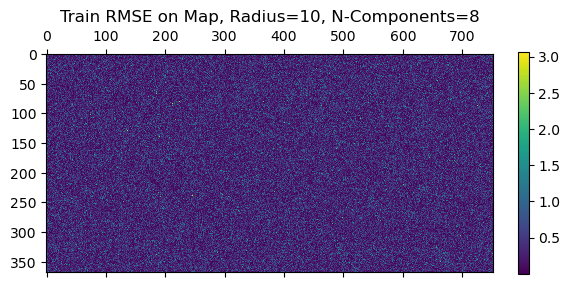

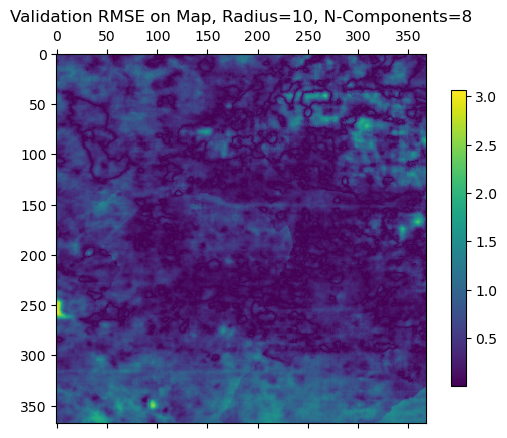

In [33]:
fig, ax = plt.subplots()
ax.set_title('Train RMSE on Map, Radius=10, N-Components=8')
plt.imshow(train_loss_array)
plt.colorbar(fraction=0.05, shrink=0.6)
ax.matshow(train_loss_array)
plt.show(fig)
fig, ax = plt.subplots()
ax.set_title('Validation RMSE on Map, Radius=10, N-Components=8')
plt.imshow(train_loss_array)
plt.colorbar(fraction=0.05, shrink=0.8)
ax.matshow(val_loss_array)
plt.show(fig)